In [1]:
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sbn
from typing import Any, List, Type
from mpl_toolkits.mplot3d import Axes3D
from timeseries import *
import matplotlib
from datetime import datetime

In [2]:
#df=pd.read_csv("ActonMay4.csv")
df = pd.read_csv('ActonMay4.csv', index_col=False, infer_datetime_format=True, parse_dates=[4, 5])

In [3]:
detector_sample=df["detector_id"].drop_duplicates().sample(10).to_numpy()

In [4]:
MA(df,'N25/011d2', 5)

188.33333333333334

In [5]:
MALD(df,"N24/012a1",24, 13)*24

1.5540348425339148

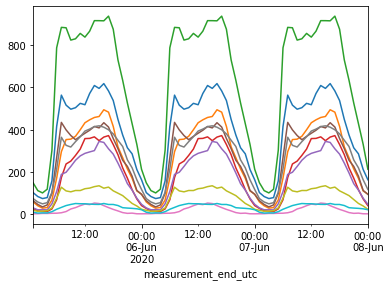

In [8]:
y=MALDforecast(df, detector_sample, 10, 3, display=True)

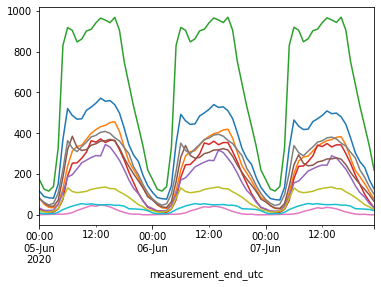

In [7]:
x=holt_winters(df, detector_sample, 20, 3, display=True, alpha=0.05, beta=0.05, gamma=0.2)

In [9]:
count_baseline(df, detector_sample, 15, 2)

,detector_id,lon,lat,measurement_start_utc,measurement_end_utc,baseline,Unnamed: 0,count
0,N25/124a3,-0.281034,51.491616,2020-06-02 23:00:00,2020-06-03 00:00:00,165.826602,NaN,NaN
1,N25/124a3,-0.281034,51.491616,2020-06-03 00:00:00,2020-06-03 01:00:00,118.338074,66549.0,90.0
2,N25/124a3,-0.281034,51.491616,2020-06-03 01:00:00,2020-06-03 02:00:00,101.836693,66550.0,80.0
3,N25/124a3,-0.281034,51.491616,2020-06-03 02:00:00,2020-06-03 03:00:00,97.348325,66551.0,78.0
4,N25/124a3,-0.281034,51.491616,2020-06-03 03:00:00,2020-06-03 04:00:00,165.235930,66552.0,83.0
...,...,...,...,...,...,...,...,...
475,N25/089b1,-0.272765,51.492628,2020-06-04 18:00:00,2020-06-04 19:00:00,38.731221,36258.0,45.0
476,N25/089b1,-0.272765,51.492628,2020-06-04 19:00:00,2020-06-04 20:00:00,35.250806,36259.0,27.0
477,N25/089b1,-0.272765,51.492628,2020-06-04 20:00:00,2020-06-04 21:00:00,34.622921,36260.0,28.0
478,N25/089b1,-0.272765,51.492628,2020-06-04 21:00:00,2020-06-04 22:00:00,33.742788,36261.0,25.0


In [16]:
# def dataframe_org(df):
#     df2=df.sort_values(by=['measurement_end_utc'])
#     df2.index=pd.to_datetime(df2['measurement_end_utc'])
#     df2=df2.drop(["Unnamed: 0", "measurement_start_utc", "measurement_end_utc"], axis=1)
#     return df2
    
    

# def MA(df, detector, past_days):
#     one_D=df[df["detector_id"]==detector]
#     return(one_D.tail(n=24*past_days)['n_vehicles_in_interval'].mean())

# def MALD(df, detector, hour):
#     one_D=df[df["detector_id"]==detector]
#     hour=f'{hour:02}'
#     beta=(one_D.loc[one_D.index.strftime("%H") == hour]['n_vehicles_in_interval'].sum())/(one_D['n_vehicles_in_interval'].sum())
#     return beta

# def MAGD(df, hour):
#     hour=f'{hour:02}'
#     beta=(df.loc[df.index.strftime("%H") == hour]['n_vehicles_in_interval'].sum())/(df['n_vehicles_in_interval'].sum())
#     return beta

# def forecast(df, detectors, days_in_past, days_in_future, display=False):
#     framelist=[]
#     for detector in detectors:
#         meanV=MA(df, detector, days_in_past)
#         pred=[]
#         index=[]
#         for i in range(1, 24*days_in_future +1):
#             time=df.index[-1]+ np.timedelta64(i, 'h')
#             beta=MALD(df, detector, time.hour)
#             index.append(time)
#             pred.append(beta*24*meanV)

#         df2 = pd.DataFrame({"measurement_end_utc":index, "n_vehicles_in_interval": pred})
#         df2["detector_id"]=detector
#         df2["lon"] = df[df["detector_id"]==detector]["lon"][0]
#         df2["lat"] = df[df["detector_id"]==detector]["lat"][0]
        
#         framelist.append(df2)
#     DF=pd.concat(framelist)
#     DF=DF.set_index('measurement_end_utc')
    
#     if(display):
#         for detector in detectors:
#             DF[DF["detector_id"]==detector]["n_vehicles_in_interval"].plot()
    
#     return DF
        
    

In [12]:
# def holt_winters(df, detectors, days_in_past, days_in_future, alpha=0.1, beta=0.1, gamma=0.1, display=False):
#     framelist=[]
#     for detector in detectors:
#         S=1; T=1; I=np.ones(24);
#         past=df[df["detector_id"]==detector].tail(n=24*days_in_past)
#         for i in range(0, len(past)):
#             h=i%24
#             c = past["n_vehicles_in_interval"][i]
#             Snew = (alpha*(c/I[h])) + (1-alpha)*(S + T)
#             T = beta*(Snew - S) + (1-beta)*T
#             I[h] = gamma*(c/Snew) + (1-gamma)*I[h]
#             S=Snew

#         baseline=[]
#         index = []
#         for j in range(0, days_in_future*24):
#             time=df.index[-1]+ np.timedelta64(j, 'h')
#             h=j%24
#             b=(S + T)*I[h]
#             baseline.append(b)
#             index.append(time)

#             Snew = (alpha*(b/I[h])) + (1-alpha)*(S + T)
#             T = beta*(Snew - S) + (1-beta)*T
#             I[h] = gamma*(b/Snew) + (1-gamma)*I[h]
#             S=Snew

#         df2 = pd.DataFrame({"measurement_end_utc":index, "n_vehicles_in_interval": baseline})
#         df2["detector_id"]=detector
#         df2["lon"] = df[df["detector_id"]==detector]["lon"][0]
#         df2["lat"] = df[df["detector_id"]==detector]["lat"][0]
#         framelist.append(df2)
#     DF=pd.concat(framelist)
#     DF=DF.set_index('measurement_end_utc')
    
#     if(display):
#         for detector in detectors:
#             DF[DF["detector_id"]==detector]["n_vehicles_in_interval"].plot()

#     return DF
        
        
        
    
    